In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c tech-olympiad-2024-bahrain-nssa-challenge

 73% 254M/349M [00:00<00:00, 1.04GB/s]
100% 349M/349M [00:00<00:00, 580MB/s] 


In [ ]:
!mkdir -p dataset
!unzip -q tech-olympiad-2024-bahrain-nssa-challenge.zip -d dataset
!rm tech-olympiad-2024-bahrain-nssa-challenge.zip

replace dataset/Images/Images/000112f3-ec99-4a2e-9f4a-5c1b9910a977.TIF? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!mkdir -p pretrained
!mkdir -p model

In [ ]:
##################### Saving Prereained Models ######################

import torch
import timm


models_to_save = [
    'efficientnet_b0',
    'mobilenetv3_large_100',
    'resnet18',
    'convnext_tiny',
    'swin_tiny_patch4_window7_224',
    'vit_base_patch16_224',
    'convnext_base',
    "densenet121",
    "resnet50"
]

for name in models_to_save:
    print(f"🔹 Downloading & saving {name}...")
    model = timm.create_model(name, pretrained=True)
    torch.save(model.state_dict(), f"pretrained/{name}_pretrained.pth")

print("✅ All models saved locally!")




🔹 Downloading & saving efficientnet_b0...
🔹 Downloading & saving mobilenetv3_large_100...
🔹 Downloading & saving resnet18...
🔹 Downloading & saving convnext_tiny...
🔹 Downloading & saving swin_tiny_patch4_window7_224...
🔹 Downloading & saving vit_base_patch16_224...
🔹 Downloading & saving convnext_base...
🔹 Downloading & saving densenet121...
🔹 Downloading & saving resnet50...
✅ All models saved locally!


In [ ]:
## Data Loading && Understamding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import os
from tqdm import tqdm
import glob

## EDA
from PIL import Image
from sklearn.decomposition import PCA
import cv2


## Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split


## Modelling
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

## Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [ ]:
image_folder = "/content/dataset/Images/Images"
train_csv = "/content/dataset/train.csv"
test_csv = "/content/dataset/test.csv"
val_csv = "/content/dataset/validation.csv"

In [ ]:
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)
df_val = pd.read_csv(val_csv)

df_train.head()

,name,clear,agriculture,bare_ground,forest,unshaded,partly_cloudy,cloudy,shaded,partly_shaded,habitation,water
0,f1be559d-e615-49c8-937a-b4d4cac0e174.TIF,0,1,0,0,1,0,1,0,0,0,0
1,00b31dd8-cb46-4b46-a9e7-23b92d40b1ab.TIF,1,1,1,1,1,0,0,0,0,0,0
2,8707b2af-2232-4403-a556-68ad406ff59d.TIF,0,1,0,1,0,1,0,0,1,0,0
3,d4098344-63c9-452e-92c4-c95147304a07.TIF,1,1,0,1,1,0,0,0,0,0,0
4,f78a39e8-c76c-4d1c-8134-1aff9210ca01.TIF,1,1,1,1,1,0,0,0,0,0,0


In [ ]:
labels = ['clear', 'agriculture', 'bare_ground', 'forest', 'unshaded', 'partly_cloudy', 'cloudy', 'shaded', 'partly_shaded', 'habitation', 'water']

for i in labels:
    print(f"{i} in train contain: {df_train[i].value_counts()}")

clear in train contain: clear
0    2040
1    1448
Name: count, dtype: int64
agriculture in train contain: agriculture
1    2539
0     949
Name: count, dtype: int64
bare_ground in train contain: bare_ground
0    2355
1    1133
Name: count, dtype: int64
forest in train contain: forest
1    1746
0    1742
Name: count, dtype: int64
unshaded in train contain: unshaded
1    2760
0     728
Name: count, dtype: int64
partly_cloudy in train contain: partly_cloudy
0    2515
1     973
Name: count, dtype: int64
cloudy in train contain: cloudy
0    2421
1    1067
Name: count, dtype: int64
shaded in train contain: shaded
0    3319
1     169
Name: count, dtype: int64
partly_shaded in train contain: partly_shaded
0    2929
1     559
Name: count, dtype: int64
habitation in train contain: habitation
0    3257
1     231
Name: count, dtype: int64
water in train contain: water
0    3322
1     166
Name: count, dtype: int64


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3488 entries, 0 to 3487
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           3488 non-null   object
 1   clear          3488 non-null   int64 
 2   agriculture    3488 non-null   int64 
 3   bare_ground    3488 non-null   int64 
 4   forest         3488 non-null   int64 
 5   unshaded       3488 non-null   int64 
 6   partly_cloudy  3488 non-null   int64 
 7   cloudy         3488 non-null   int64 
 8   shaded         3488 non-null   int64 
 9   partly_shaded  3488 non-null   int64 
 10  habitation     3488 non-null   int64 
 11  water          3488 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 327.1+ KB


In [1]:
!pip install imagecodecs
def show_samples(df, data_dir, n_per_class=5, image_paths="filename", labels="genus"):
    subset = df.sample(min(n_per_class, len(df)))
    plt.figure(figsize=(n_per_class * 2, 2))

    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = os.path.join(data_dir, row[image_paths])
        try:
            img_array = tifffile.imread(img_path)
        except Exception:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)

        if img_array.ndim == 2:
            img_array = np.stack([img_array]*3, axis=-1)
        elif img_array.ndim == 3 and img_array.shape[2] > 3:
            img_array = img_array[:, :, :3]
        img_display = img_array[..., :3] / np.max(img_array)
        plt.subplot(1, n_per_class, i + 1)
        plt.imshow(img_display)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 41.8 MB/s eta 0:00:00


tifffile: 2024.8.30
imagecodecs: 2025.8.2


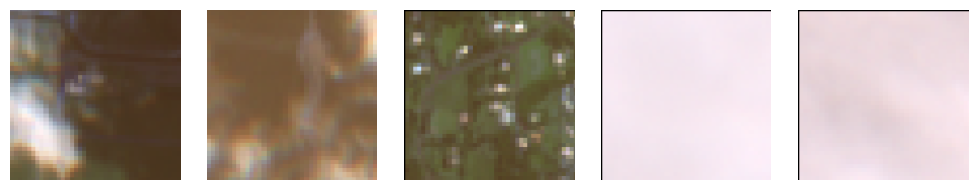

In [ ]:

import imagecodecs
import tifffile

print("tifffile:", tifffile.__version__)
print("imagecodecs:", imagecodecs.__version__)

show_samples(df_train, data_dir = image_folder, image_paths = "name")



In [ ]:
#pip install --force-reinstall "tifffile==2024.8.30"


In [ ]:
import tifffile, imagecodecs

# Force register imagecodecs into tifffile plugin system
tifffile.TIFF.DECODE_LZW = imagecodecs.lzw_decode
tifffile.TIFF.DECODE_ADOBE_DEFLATE = imagecodecs.zlib_decode
tifffile.TIFF.DECODE_LZMA = imagecodecs.lzma_decode
tifffile.TIFF.DECODE_PACKBITS = imagecodecs.packbits_decode


In [ ]:
!pip install imagecodecs
width, heights, ratio = [], [], []

for path in tqdm(df_train["name"], desc="Analyzing image sizes"):
    img_path = os.path.join(image_folder, path)
    try:
        img = tifffile.imread(img_path)

        # Handle different shapes
        if img.ndim == 2:  # grayscale
            h, w = img.shape
        elif img.ndim == 3:  # multi-channel
            h, w = img.shape[:2]
        else:
            raise ValueError(f"Unexpected shape {img.shape} for {path}")

        width.append(w)
        heights.append(h)
        ratio.append(round(w / h, 3))
    except Exception as e:
        print(f"⚠️ Image {img_path} cannot be opened: {e}")
        width.append(None)
        heights.append(None)
        ratio.append(None)
df_train["width"] = width
df_train["heights"] = heights
df_train["ratio"] = ratio

df_train[['width', 'heights', 'ratio']].head()

Analyzing image sizes: 100%|██████████| 3488/3488 [00:13<00:00, 254.32it/s]


,width,heights,ratio
0,129,129,1.0
1,128,128,1.0
2,128,128,1.0
3,129,129,1.0
4,128,128,1.0


In [ ]:
class TifImageDataset(Dataset):
    def __init__(self, df, img_dir, label_cols=None, transform=None, to_rgb=True, max_channels=3):
        """
        Custom PyTorch dataset to handle .tif/.tiff and standard images.

        Args:
            df (pd.DataFrame): dataframe berisi nama file dan (opsional) label.
            img_dir (str): path ke folder berisi gambar.
            label_cols (list): kolom label di df. Jika None → hanya image.
            transform (Compose): augmentasi/transforms torchvision.
            to_rgb (bool): jika True, konversi ke 3 channel (RGB).
            max_channels (int): jika multi-band, ambil n channel pertama.
        """
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.label_cols = label_cols
        self.transform = transform
        self.to_rgb = to_rgb
        self.max_channels = max_channels

    def __len__(self):
        return len(self.df)

    def _load_tif_image(self, path):
        """Load image from TIF/TIFF with tifffile"""
        img = tifffile.imread(path)  # np.ndarray

        # Handle grayscale
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)

        # Handle multiband (keep first N channels)
        elif img.ndim == 3 and img.shape[2] > self.max_channels:
            img = img[:, :, :self.max_channels]

        # Convert to 8-bit if needed (normalize)
        if img.dtype != np.uint8:
            img = np.clip(img / img.max(), 0, 1)
            img = (img * 255).astype(np.uint8)

        return Image.fromarray(img)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'name']
        img_path = os.path.join(self.img_dir, img_name)
        ext = os.path.splitext(img_name)[1].lower()

        # ========== Handle multiple formats (.tif, .png, .jpg) ==========
        if ext in ['.tif', '.tiff']:
            image = self._load_tif_image(img_path)
        else:
            image = Image.open(img_path).convert("RGB")
        # ================================================================

        if self.transform:
            image = self.transform(image)

        if self.label_cols is not None:
            labels = torch.tensor(self.df.loc[idx, self.label_cols].values.astype('float32'))
            return image, labels

        return image

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_dataset = TifImageDataset(
    df=df_train,
    img_dir=image_folder,
    label_cols=labels,
    transform=train_transform
)

img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) tensor([0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])


In [ ]:
val_dataset = TifImageDataset(
    df=df_val,
    img_dir=image_folder,
    label_cols=labels,
    transform=val_transform
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32,  shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:

class Trainer:
    def __init__(self, model, device, criterion, optimizer, early_stopping_patience,
                 scheduler, save_path, wscheduler=None, multilabel=False):
        self.model = model.to(device)
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.early_stopping_patience = early_stopping_patience
        self.save_path = save_path
        self.best_val_loss = float("inf")
        self.epochs_no_improve = 0
        self.multilabel = multilabel  # <-- deteksi manual / auto

    def _is_multilabel(self, labels):
        # otomatis deteksi multi-label jika label punya lebih dari 1 kolom
        return len(labels.shape) > 1 and labels.shape[1] > 1

    def _compute_metrics(self, outputs, labels):
        """Menghitung metrik sesuai tipe problem."""
        if self.multilabel or self._is_multilabel(labels):
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            correct = (preds == labels.int()).sum().item()
            total = torch.numel(labels)
            acc = 100 * correct / total

            # opsional: hitung f1
            f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average="micro", zero_division=0)
            return acc, f1

        else:
            _, preds = torch.max(outputs, 1)
            acc = 100 * (preds == labels).sum().item() / labels.size(0)
            return acc, None

    def train_one_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        total_acc, total_f1, total_samples = 0.0, 0.0, 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * images.size(0)

            acc, f1 = self._compute_metrics(outputs, labels)
            total_acc += acc * images.size(0)
            if f1 is not None:
                total_f1 += f1 * images.size(0)
            total_samples += images.size(0)

        train_loss = running_loss / total_samples
        train_acc = total_acc / total_samples
        train_f1 = total_f1 / total_samples if total_f1 > 0 else None

        return train_loss, train_acc, train_f1

    def validate_per_epoch(self, val_loader):
        self.model.eval()
        val_loss, val_acc, val_f1, total_samples = 0.0, 0.0, 0.0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                acc, f1 = self._compute_metrics(outputs, labels)
                val_acc += acc * images.size(0)
                if f1 is not None:
                    val_f1 += f1 * images.size(0)
                total_samples += images.size(0)

        val_loss /= total_samples
        val_acc /= total_samples
        val_f1 = val_f1 / total_samples if val_f1 > 0 else None

        return val_loss, val_acc, val_f1

    def fit(self, train_loader, val_loader, num_epochs):
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_f1": [], "val_f1": []}

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            train_loss, train_acc, train_f1 = self.train_one_epoch(train_loader)
            val_loss, val_acc, val_f1 = self.validate_per_epoch(val_loader)

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)
            history["train_f1"].append(train_f1)
            history["val_f1"].append(val_f1)

            print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%"
                  f"{f', F1: ' + str(round(train_f1, 4)) if train_f1 else ''}")
            print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%"
                  f"{f', F1: ' + str(round(val_f1, 4)) if val_f1 else ''}")

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.save_path)
                self.epochs_no_improve = 0
            else:
                self.epochs_no_improve += 1
                if self.early_stopping_patience and self.epochs_no_improve >= self.early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        print("\nTraining complete.")
        return history



In [ ]:
class ResNet50(nn.Module):
  def __init__(self, num_classes, pretrained=None):
    super(ResNet50, self).__init__()

    self.feature_extraction = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size = 5, padding = 2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2),

          nn.Conv2d(32, 64, kernel_size = 3, padding = 2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2),

          nn.Conv2d(64, 128, kernel_size = 5, padding = 2),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2),

          nn.Conv2d(128, 256, kernel_size = 5, padding = 2),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2),
    )

    self.global_cnn = timm.create_model("resnet50", pretrained=False)
    self.global_cnn.load_state_dict(torch.load(pretrained))
    for param in self.global_cnn.parameters():
        param.requires_grad = False

    for param in self.global_cnn.layer4[2].parameters():
        param.requires_grad = True


    in_features = self.global_cnn.get_classifier().in_features
    self.global_cnn.fc = nn.Identity()
    self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    self.fusion_head = nn.Sequential(
            nn.Linear(in_features + 256 , 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

  def forward(self, x):
    local_features = self.feature_extraction(x)
    local_feat = self.global_pool(local_features)
    local_feat = torch.flatten(local_feat, 1)

    global_features = self.global_cnn(x)

    fused = torch.cat((local_feat, global_features), dim=1)

    out = self.fusion_head(fused)
    return out


In [ ]:
model = ResNet50(num_classes = len(labels), pretrained="/content/pretrained/resnet50_pretrained.pth")

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
trainer = Trainer(
    model = model,
    device = device,
    criterion = criterion,
    optimizer = optimizer,
    early_stopping_patience = 10,
    save_path = "model/finetuned-resnet.pth",
    scheduler = scheduler,
    multilabel=True
)

In [ ]:
history = trainer.fit(train_loader, val_loader, num_epochs = 50)


Epoch 1/50


Train Loss: 0.4005, Acc: 84.14%, F1: 0.7494
Val   Loss: 0.2900, Acc: 87.70%, F1: 0.8077

Epoch 2/50


Train Loss: 0.2777, Acc: 88.09%, F1: 0.8158
Val   Loss: 0.2433, Acc: 89.88%, F1: 0.8426

Epoch 3/50


Train Loss: 0.2428, Acc: 89.78%, F1: 0.843
Val   Loss: 0.2197, Acc: 91.11%, F1: 0.8623

Epoch 4/50


Train Loss: 0.2252, Acc: 90.55%, F1: 0.8555
Val   Loss: 0.2090, Acc: 91.38%, F1: 0.8659

Epoch 5/50


Train Loss: 0.2129, Acc: 91.06%, F1: 0.8637
Val   Loss: 0.2093, Acc: 91.82%, F1: 0.8742

Epoch 6/50


Train Loss: 0.2057, Acc: 91.49%, F1: 0.8704
Val   Loss: 0.1938, Acc: 92.38%, F1: 0.8839

Epoch 7/50


Train Loss: 0.1998, Acc: 91.85%, F1: 0.876
Val   Loss: 0.1927, Acc: 92.24%, F1: 0.8801

Epoch 8/50


Train Loss: 0.1925, Acc: 92.00%, F1: 0.8784
Val   Loss: 0.1806, Acc: 92.61%, F1: 0.886

Epoch 9/50


Train Loss: 0.1921, Acc: 92.03%, F1: 0.8788
Val   Loss: 0.1803, Acc: 92.93%, F1: 0.8916

Epoch 10/50


Train Loss: 0.1871, Acc: 92.21%, F1: 0.8816
Val   Loss: 0.1834, Acc: 92.87%, F1: 0.8913

Epoch 11/50


KeyboardInterrupt: 

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import io

# === konfigurasi ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/model/finetuned-resnet.pth"       # path model kamu
test_img_dir =  "/content/dataset/Images/Images"        # folder test images
multilabel = True                   # ubah sesuai task kamu
num_classes = 8                     # jumlah label
save_submission = "submission.csv"  # hasil akhir

# === load sample submission (format referensi) ===
test_df = df_test                      # gambar test
sample_df = pd.read_csv("/content/dataset/sample_submission.csv")       # referensi format submission

print("✅ Loaded test.csv and sample_submission.csv")

# pastikan nama kolom gambar sama
image_col = sample_df.columns[0]
label_cols = [c for c in sample_df.columns if c != image_col]

# pastikan test.csv punya kolom nama gambar
if image_col not in test_df.columns:
    test_df.rename(columns={test_df.columns[0]: image_col}, inplace=True)

print(f"Detected image column: {image_col}")
print(f"Detected label columns: {label_cols}")

# === transform untuk test ===
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === helper baca .tif / lainnya ===
def safe_load_image(path):
    ext = os.path.splitext(path)[1].lower()
    try:
        if ext in [".tif", ".tiff"]:
            with tifffile.TiffFile(path) as tif:
                img_array = tif.pages[0].asarray()
            if img_array.ndim == 2:
                img_array = np.stack([img_array]*3, axis=-1)
            elif img_array.ndim == 3 and img_array.shape[2] > 3:
                img_array = img_array[:, :, :3]
            if img_array.dtype != np.uint8:
                img_array = (img_array / np.max(img_array) * 255).astype(np.uint8)
            img = Image.fromarray(img_array)
        else:
            img = Image.open(path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Failed to open {os.path.basename(path)}: {e}")
        img = Image.new("RGB", (224, 224), color=(0, 0, 0))
    return img

# === dataset class untuk test ===
class TiffTestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, image_col="image"):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.image_col = image_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, self.image_col]
        img_path = os.path.join(self.img_dir, img_name)
        image = safe_load_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_name

# === buat dataset & dataloader ===
test_dataset = TiffTestDataset(test_df, test_img_dir, transform=test_transform, image_col=image_col)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
print("✅ Test loader ready (TIF supported).")




✅ Loaded test.csv and sample_submission.csv
Detected image column: ID
Detected label columns: ['clear', 'agriculture', 'bare_ground', 'forest', 'unshaded', 'partly_cloudy', 'cloudy', 'shaded', 'partly_shaded', 'habitation', 'water']
✅ Test loader ready (TIF supported).


AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [ ]:

with open(model_path, "rb") as f:
    byte_data = np.frombuffer(f.read(), dtype=np.uint8)
buffer = io.BytesIO(byte_data)

state_dict = torch.load(buffer, map_location=device)
model.load_state_dict(state_dict)
model.eval()

ResNet50(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
# === inference ===
all_preds, all_names = [], []

with torch.no_grad():
    for images, names in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)
        outputs = model(images)

        if multilabel:
            preds = torch.sigmoid(outputs).cpu().numpy()   # probabilitas tiap label (0–1)
        else:
            preds = torch.softmax(outputs, dim=1).cpu().numpy()

        all_preds.append(preds)
        all_names.extend(names)

# === gabung hasil ===
all_preds = np.vstack(all_preds)

# === buat dataframe hasil prediksi ===
submission_df = pd.DataFrame(all_preds, columns=label_cols)
submission_df.insert(0, image_col, all_names)

# urutkan sesuai sample_submission (jika perlu)
submission_df = submission_df.set_index(image_col).reindex(sample_df[image_col]).reset_index()

print("✅ Submission DataFrame preview:")
display(submission_df.head())



Predicting: 100%|██████████| 46/46 [00:07<00:00,  6.13it/s]

✅ Submission DataFrame preview:


,ID,clear,agriculture,bare_ground,forest,unshaded,partly_cloudy,cloudy,shaded,partly_shaded,habitation,water
0,98d410c7-0134-4ea1-8dcc-a3ac26c4403c.TIF,0.999410,0.985533,0.017483,0.987630,0.989652,0.000864,0.000084,0.001378,0.010248,0.008465,0.006751
1,4ecafff7-0ec2-406b-a05e-f11c875ab18c.TIF,0.013273,0.936750,0.486592,0.107460,0.791477,0.673860,0.311965,0.013576,0.171762,0.008793,0.029150
2,fde6e65a-c44f-4e5e-8932-e7bfec9f2c92.TIF,0.986239,0.929336,0.266085,0.910582,0.092065,0.019878,0.001546,0.698161,0.367026,0.047163,0.177565
3,17e2c45e-3281-4020-a156-3373010f3ff1.TIF,0.027983,0.999468,0.782274,0.680411,0.031285,0.957868,0.000719,0.026829,0.910915,0.030200,0.064290
4,49ffc507-1295-45eb-a1ea-31f9e4b67474.TIF,0.803787,0.980209,0.453061,0.756621,0.019288,0.215888,0.001495,0.658264,0.667566,0.025999,0.129868


💾 Submission file saved as: submission.csv


In [ ]:
# === gabung hasil prediksi ===
all_preds = np.vstack(all_preds)

# === ubah probabilitas ke 0/1 ===
binary_preds = (all_preds > 0.5).astype(int)

# === pastikan jumlah kolom sesuai label sample submission ===
if len(label_cols) > binary_preds.shape[1]:
    print(f"⚠️ Trimming {len(label_cols) - binary_preds.shape[1]} extra columns from sample_submission")
    label_cols = label_cols[:binary_preds.shape[1]]
elif len(label_cols) < binary_preds.shape[1]:
    print(f"⚠️ Model menghasilkan lebih banyak label ({binary_preds.shape[1]}) daripada sample submission ({len(label_cols)})")
    binary_preds = binary_preds[:, :len(label_cols)]

# === buat dataframe submission ===
submission_df = pd.DataFrame(binary_preds, columns=label_cols)
submission_df.insert(0, image_col, all_names)

# === simpan ke file CSV ===
submission_df.to_csv(save_submission, index=False)
print(f"✅ Binary submission saved: {save_submission}")
display(submission_df.head())


✅ Binary submission saved: submission.csv


,ID,clear,agriculture,bare_ground,forest,unshaded,partly_cloudy,cloudy,shaded,partly_shaded,habitation,water
0,98d410c7-0134-4ea1-8dcc-a3ac26c4403c.TIF,1,1,0,1,1,0,0,0,0,0,0
1,4ecafff7-0ec2-406b-a05e-f11c875ab18c.TIF,0,1,0,0,1,1,0,0,0,0,0
2,fde6e65a-c44f-4e5e-8932-e7bfec9f2c92.TIF,1,1,0,1,0,0,0,1,0,0,0
3,17e2c45e-3281-4020-a156-3373010f3ff1.TIF,0,1,1,1,0,1,0,0,1,0,0
4,49ffc507-1295-45eb-a1ea-31f9e4b67474.TIF,1,1,0,1,0,0,0,1,1,0,0


In [ ]:
!kaggle competitions submit -c tech-olympiad-2024-bahrain-nssa-challenge -f submission.csv -m "resnetxcnn"

100% 45.4k/45.4k [00:00<00:00, 234kB/s]
Successfully submitted to TechOlympiad 2024 - Bahrain - NSSA Challenge